In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters
from tqdm import tqdm

from cgtasknet.instrumetns.dynamic_generate import SNNStates
from cgtasknet.instrumetns.instrument_pca import PCA
from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask

dmparams1 = DefaultParams("DMTask").generate_params()
dmparams1["value"] = 0.0
Task = DMTask(dmparams1, mode="value")
dmparams2 = DefaultParams("DMTask").generate_params()
dmparams2["value"] = 0.3

Task2 = DMTask(dmparams2, mode="value")
dmparams3 = DefaultParams("DMTask").generate_params()
dmparams3["value"] = 0.7

Task3 = DMTask(dmparams3, mode="value")
dmparams3 = DefaultParams("DMTask").generate_params()
dmparams3["value"] = 1.0
Task4 = DMTask(dmparams3, mode="value")

feature_size = 2
output_size = 3
hidden_size = 400
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
)
if True:
    model.load_state_dict(
        torch.load(
            "Only_dm_lif_refrac_net"
        )
    )
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
inputs, target_out = Task.dataset(1)
one_trajectory_time = inputs.shape[0] * 4 - 2 + 1500 + 1500
v_mean = torch.zeros((one_trajectory_time, batch_size, hidden_size))
number_of_trials = 1
for trial in tqdm(range(number_of_trials)):
    inputs, target_out = Task.dataset(1)

    data = inputs + np.random.normal(0, 0.01, size=(inputs.shape))
    inputs2, target_out2 = Task2.dataset(1)

    data2 = inputs2 + np.random.normal(0, 0.01, size=(inputs2.shape))
    inputs3, target_out3 = Task3.dataset(1)
    data3 = inputs3 + np.random.normal(0, 0.01, size=(inputs3.shape))
    inputs4, target_out4 = Task4.dataset(1)
    data4 = inputs4 + np.random.normal(0, 0.01, size=(inputs4.shape))

    data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    data = np.concatenate((data, data2), axis=0)
    data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    data = np.concatenate((data, data3))
    data = np.concatenate((data, np.zeros((500, data.shape[1], data.shape[2]))))
    data = np.concatenate((data, data4))
    data = np.concatenate((data, np.zeros((1500, data.shape[1], data.shape[2]))))

    data = torch.from_numpy(data).type(torch.float32)

    # target_out = torch.from_numpy(target_out).type(torch.float)

    states_generator = SNNStates(model)
    out, states = states_generator.states(data, first_state)
    v = []
    s = []
    i = []
    for j in range(len(states)):
        v.append(states[j].lif.v)
        s.append(states[j].lif.z)
        i.append(states[j].lif.i)
    v = torch.stack(v).detach()
    # s = torch.stack(s).detach()
    # i = torch.stack(i).detach()
    # plt.plot(data[:, 0, 7])
    # plt.plot(out.detach().cpu().numpy()[:, 0, 3])
    # plt.plot(out.detach().cpu().numpy()[:, 0, 4])
    # plt.show()
    v_mean += v
v_mean /= float(number_of_trials)
pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))


s = torch.stack(s).detach()
s = s.cpu().numpy()


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


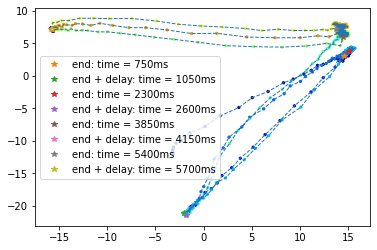

In [20]:

cmap = np.arange(0, len(v_mean))
first = 0
second = 1
plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[:, second], c=cmap, cmap="jet", s=5)


trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"end: time = {time}ms",
    )
    time += delay
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"end + delay: time = {time}ms",
    )

    time += delay_beetween + trialstop


plt.legend()
plt.show()




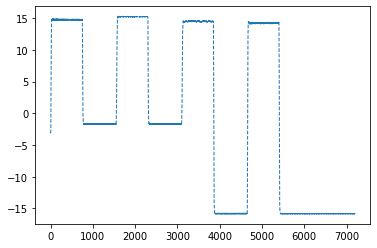

In [17]:
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)

plt.show()


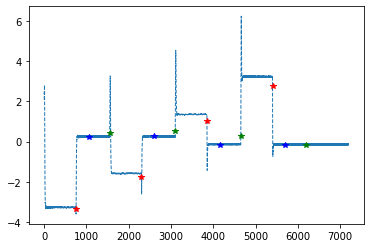

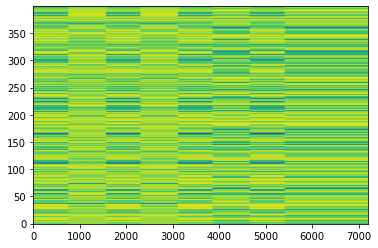

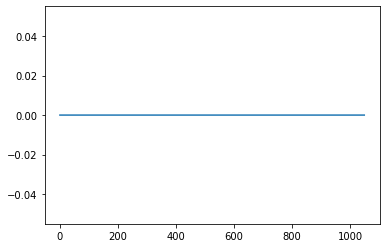

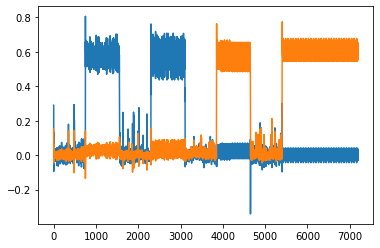

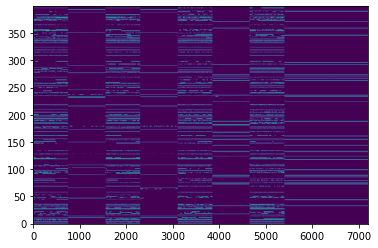

In [18]:


pca_show = 2
plt.plot(pca.numpy()[:, pca_show], "--", linewidth=1)
trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot([time], pca.numpy()[time, pca_show], "*", c="r")
    time += delay
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="b",
    )
    time += delay_beetween
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="g",
    )
    time += trialstop
plt.show()

plt.imshow(v_mean.numpy()[:, 0, :].T, aspect="auto", origin="lower")
plt.show()

inputs, target_out = Task.dataset(1)

plt.plot(inputs[:, 0, 1])
plt.show()

# plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])
plt.show()



plt.imshow(s[:, 0, :].T, aspect="auto", origin="lower", vmax=.8)
plt.show()